In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from typing import Any, Callable, NamedTuple, Tuple, Union
Step = int
Schedule = Callable[[Step], float]

from IPython import display
from IPython.display import Image, clear_output
from PIL import Image
import glob, os, shutil
import os.path

import time

import scipy.io as io
import scipy.sparse.csgraph as csgraph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy as sp
from scipy.stats import gaussian_kde
from scipy.linalg import null_space

import jax
from jax import jit, vmap, random, grad, value_and_grad, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import optimizer
from jax import numpy as jnp

from functools import partial
import itertools

import math
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import seaborn as sns

import datetime
from tqdm.notebook import tqdm

import networkx as nx

%load_ext autoreload
%autoreload 2

In [3]:
import utils
from utils import *
from optimizers import *

In [4]:
# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/
graphs = ['qh882','dwt_1005','3elt','commanche_dual','bcsstk31']
graphdir = './testcases/'
graphpostfix = '3elt'
assert graphpostfix in graphs
grid_testcase = nx.grid_graph(dim=(50, 50))
#grid_testcase = nx.triangular_lattice_graph(25,25)
#grid_testcase = nx.cycle_graph(100)
grid_testcase_adjacency = nx.adjacency_matrix(grid_testcase).toarray().astype(np.int16)
DEBUG=False
if DEBUG:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=grid_testcase_adjacency, plot_adjacency=False, verbose=True)
else:
    graph, G, A, L, D, n = load_graph(graphdir+graphpostfix, A=None, plot_adjacency=False, verbose=True)


Name: 
Type: Graph
Number of nodes: 4720
Number of edges: 13722
Average degree:   5.8144


In [5]:
del G
del A
del D

In [6]:
@jit
def project(X1, C, E_0, c=jnp.array([0,0])):
    C1 = X1.T@X1
    C1sqrt = utils._sqrtm(C1)
    Csqrt = utils._sqrtm(C)
    U,s,V = jnp.linalg.svd(Csqrt@C1sqrt)
    X = X1@jnp.linalg.inv(C1sqrt)@U@V.T@Csqrt

    #negdef = jnp.all(jnp.linalg.eigvals(X.T@E_0) <= 1e-8)
    U_E, _, V_E = jnp.linalg.svd(X.T@E_0)
    X = X@(-U_E@V_E.T)
    #X = jax.lax.cond(negdef,
    #                 lambda _ : X@(-U_E@V_E.T),
    #                 lambda _ : X,
    #                 operand=None
    #                )
    return X.real

@jit
def _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    E_0 = stp*jnp.vstack([b_x,b_y]).T
    X_k_x = X_k[:,0] - stp*A_x@X_k[:,0]
    X_k_y = X_k[:,1] - stp*A_y@X_k[:,1]
    X_k_t = jnp.vstack([X_k_x,X_k_y]).T - E_0
    X_k_t = project(X_k_t, C, E_0)
    return X_k_t

def pgd(X_k, A_x, A_y, b_x, b_y, C, convergence_criterion, 
           maxiters=1000, alpha=1e-2, beta=0.9):
    """Perform iterations of PGD, without autograd."""
    E_0 = jnp.stack([b_x, b_y], axis=1)
    L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
    
    report = {'x':None, 'lossh':[f(X_k, A_x, A_y, b_x, b_y).item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_pgd(X_k, L, C, A_x, b_x, b_y).item()], 'step_sizes':[1], 'L':[L]}
    
    for k in tqdm(range(maxiters)):
        # backtracking line search
        f_xp = 1e8
        stp = 1

        f_x, g = value_and_grad(f)(X_k, A_x, A, b_x, b_y)
        X_k_t = X_k
        derphi=1
        while f_xp >= f_x: #- alpha * stp * derphi:
            stp *= beta
            X_k_t = _step_noautograd(stp, X_k, A_x, A_y, b_x, b_y)    
            f_xp = f(X_k_t, A_x, A_y, b_x, b_y)
        
            if stp < 1e-6:
                break  

        X_k = X_k_t
        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
        
        report['lossh'].append(f_xp.item())
        report['sln_path'].append(np.asarray(X_k))
        report['L'].append(np.asarray(L))
        report['step_sizes'].append(stp)
        report['foc'].append(foc_pgd(X_k, L, C, A_x, b_x, b_y).item())
        
        if len(report['lossh']) > 2 and \
        np.abs(report['lossh'][-2] - report['lossh'][-1]) <= convergence_criterion:
            print('converged')
            break
    report['x'] = X_k
        
    return report

@jit
def step(i, opt_state, A_x, A_y, b_x, b_y):
    """Perform a single gradient (using autograd) + projection step with adaptive momentum."""
    X_k = get_params(opt_state)
    f_x, g = value_and_grad(f)(X_k, A_x, A_y, b_x, b_y)
    return opt_update(i, g, opt_state), f_x

def pgd_autograd(opt_params, A_x, A_y, b_x, b_y, C, convergence_criterion, maxiters=1000):
    """Perform iterations of PGD, with autograd """
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = jnp.stack([b_x, b_y], axis=1)
    L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)
    
    report = {'x':None, 'lossh':[f(X_k, A_x, A_y, b_x, b_y).item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_pgd(X_k, L, C, A_x, b_x, b_y).item()], 'step_sizes':[1], 'L':[L]}
    
    for k in tqdm(range(maxiters)):
        opt_state, f_k = step(k, opt_state, A_x, A_y, b_x, b_y)
        X_k = get_params(opt_state)

        L = jnp.linalg.inv(C)@X_k.T@(A_x@X_k+E_0)

        report['lossh'].append(f_k.item())
        report['sln_path'].append(np.asarray(X_k))
        report['L'].append(np.asarray(L))
        report['foc'].append(foc_pgd(X_k, L, C, A_x, b_x, b_y).item())
        
        if len(report['lossh']) > 2 and \
        np.abs(report['lossh'][-2] - report['lossh'][-1]) <= convergence_criterion:
            print('converged')
            break
            
    report['x'] = X_k
        
    return report

@jit
def _step(i, opt_state, Z):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

@partial(jit, static_argnums=(3,))
def __step(i, opt_state, Z, opt_update):
    """Perform a single descent + projection step with arbitrary descent direction."""
    return opt_update(i, Z, opt_state)

def _D_Z(X, A, P, d, e):
    I = jnp.eye(A.shape[0])
    Ad = A + d*I
    
    Del = jnp.linalg.solve(X.T@jnp.linalg.solve(Ad, X), X.T)@jnp.linalg.solve(Ad, e)
    Z = jnp.linalg.solve(Ad, -X@Del + e)
    
    return Del, Z

@jit
def _sqp(A, P, L, E_0, X):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvals(L)
    idx = w.argsort() 
    w = w[idx]
    E = -E_0 - (A@X + X@L)
    
    #Aw = jnp.linalg.eigvals(A)
    #idx = w.argsort() 
    ##Aw = Aw[idx]
    #Aw0 = Aw[0]
    #Aw1 = Aw[1]
    
    Del_0, Z_0 = _D_Z(X, A, P, w[0], E[:,0])
    Del_1, Z_1 = _D_Z(X, A, P, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del    

def D_Z(X, A, P, d, e):
    I = jnp.eye(A.shape[0])
    Ad = A + d*I
    ADinvP = jnp.linalg.solve(Ad, P.T)
    
    Del_1 = (X.T@P)@ADinvP@X
    Del = jnp.linalg.solve(Del_1, X.T)@P@ADinvP@e
    
    Z = P@ADinvP@(-X@Del + e)

    return Del, Z

@jit
def sqp(A, P, pAp, L, E_0, X):
    """Perform an iteration of SQP.""" 
    w = jnp.linalg.eigvals(L)
    idx = w.argsort()  
    w = w[idx]
    E = -E_0 - (pAp@X + X@L)
    
    Del_0, Z_0 = D_Z(X, A, P, w[0], E[:,0])
    Del_1, Z_1 = D_Z(X, A, P, w[1], E[:,1])
    
    Z = jnp.stack([Z_0, Z_1], axis=1)
    Del = jnp.stack([Del_0, Del_1], axis=1)
    
    return Z, Del    

def newton(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
           maxiters=100, alpha=1e-2, beta=0.9, initL=True):
    """Perform iterations of PND + backtracking line search."""    
    opt_state, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_0 = np.stack([b_x, b_y], axis=1)
   
    pAp = P@A@P.T

    if initL:
        L = L_init(X_k, C, pAp, E_0)
        #L_sym = (L + L.T)/2
        #L = L_sym
    
    report = {'x':None, 'lossh':[f(X_k, pAp, pAp, b_x, b_y).item()], 'sln_path':[np.asarray(X_k)], 
            'foc':[foc_sqp(X_k, L, C, pAp, E_0).item()], 'step_sizes':[1], 'L':[L]}
    
    cc = 0

    for k in tqdm(range(maxiters)):         
        #Z, Del = sqp(A, P, pAp, L, E_0, X_k)
        Z, Del = _sqp(pAp, P, L, E_0, X_k)
        
        # backtracking line search
        f_xp = 1e8
        stp = 1
        f_x, gr = value_and_grad(f)(X_k, pAp, pAp, b_x, b_y)
        #derphi = jnp.trace(gr.T@Z)
        derphi = 1
        len_p = jnp.linalg.norm(Z)
        X_k_t = X_k
        
        opt_state_t = opt_state
        
        while f_xp >= f_x: #- alpha * stp * derphi:
            stp *= beta
            #opt_state_t = _step(stp, opt_state, -Z)
            opt_state_t = __step(stp, opt_state, -Z, opt_update)
            X_k_t = get_params(opt_state_t)
            f_xp = f(X_k_t, pAp, pAp, b_x, b_y)
        
            if stp * len_p < 1e-8:
                break    
        L = L + stp*Del
        foc = foc_sqp(X_k, L, C, pAp, E_0)
        
        opt_state = opt_state_t
        X_k = get_params(opt_state_t)
        
        report['sln_path'].append(np.asarray(X_k))
        report['step_sizes'].append(stp)
        report['foc'].append(foc.item())
        report['lossh'].append(f_xp.item())
        report['L'].append(np.asarray(L))
        
        #f len(report['lossh']) > 2 and np.abs(report['lossh'][-2] - report['lossh'][-1]) <= convergence_criterion:
        if len(report['lossh']) > 2 and np.abs(foc.item()) <= convergence_criterion:
            cc += 1
            if cc > 10:
                print('converged')
                break
        if cc > 0:
            cc -= 1
            
    return report
    
def ssm(opt_params, A, P, L, C, X_k, b_x, b_y, convergence_criterion, 
        maxiters=10, alpha=1e-2, beta=0.9):
    """
    1. compute newton direction z = sqp(X, Z, v, Ax + E0) & subspace S
    2. approximate locally optimal X, L on S; X = min F(\hat{X}, B, V.T@E0)
    """
    opt_state, opt_init, opt_update, get_params = opt_params
    X_k = get_params(opt_state)
    E_00 = np.stack([b_x, b_y], axis=1)
   
    pAp = P@A@P.T

    #L = L_init(X_k, C, pAp, E_0)
    
    #report = {'x':None, 'lossh':[f(X_k, pAp, pAp, b_x, b_y).item()], 'sln_path':[np.asarray(X_k)], 
    #        'foc':[foc_sqp(X_k, L, C, pAp, E_0).item()], 'step_sizes':[1], 'L':[L]}
    
    cc = 0
    v = np.zeros_like(X_k)
    L = np.eye(2)
    results = None
    E_0 = E_00
    for k in tqdm(range(maxiters)):     
        'Subspace computation'
        Z, Del = _sqp(pAp, P, L, E_0, X_k)
        S = [X_k, Z, v, pAp@X_k+E_0]
        Q, _ = jnp.linalg.qr(jnp.concatenate(S,axis=-1), mode='reduced')
        B=Q.T@pAp@Q
        
        'initialize wrt subspace'
        X_k = np.linalg.pinv(Q)@X_k
        E_0 = Q.T@E_00
        X_k = project(X_k, C, E_0)
        
        opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: z, 
                                                        E_0, C))    
        
        opt_state = opt_init(X_k)       
        result = newton((opt_state, opt_update, get_params), pAp, Q.T, L, C, X_k, E_0[:,0], E_0[:,1], 
                        convergence_criterion=convergence_criterion, maxiters=10, alpha=0.0, beta=0.9, initL=True) 
        
        w_v, v_v = jnp.linalg.eig(B)
        idx = w_v.argsort()
        v_v = v_v[idx]
        v=Q@v_v[:,1:3]
        
        X_k = result['sln_path'][-1]
        L = result['L'][-1]
        
        X_k = Q@X_k
        E_0 = Q@E_0
        X_k = project(X_k, C, E_0)
        
        if results == None:
            results = result
            results['sln_path'] = [X_k]
            results['lossh'] = [result['lossh'][-1]]            
        
        results['lossh'].extend(result['lossh'])
        results['sln_path'].extend([X_k]*len(result['lossh']))
        results['foc'].extend(result['foc'])
        results['step_sizes'].extend(result['step_sizes'])
    return results

In [7]:
def map_vars(A, X_k, fixed_indices, centercons, decomp=True):
    """Preprocess variables """ 
    N = A.shape[0] 
    k = fixed_indices.shape[0]
    fixed_idx = np.zeros((k,N))
    for i in range(k):
        fixed_idx[i,fixed_indices[i]] += 1
        
    if decomp:
        boolean_fixed_idx = fixed_idx.sum(0).astype(bool)
        boolean_nonfixed_idx = (1-fixed_idx.sum(0)).astype(bool)

        X_1x = X_k[boolean_fixed_idx,0]
        X_1y = X_k[boolean_fixed_idx,1]
        X_2  = X_k[boolean_nonfixed_idx]
        A_12 = A[boolean_fixed_idx, :]
        A_12 = A_12[:, boolean_nonfixed_idx] 

        b_x = X_1x@A_12
        b_y = X_1y@A_12
        X_k = X_2

        A = A[boolean_nonfixed_idx, :]
        A = A[:,boolean_nonfixed_idx]
        P = np.eye(A.shape[0])

        constraints = np.expand_dims(np.ones(X_2.shape[0]),0)
        P = null_space(constraints).T
        P = P * np.sign(P[0,0])
        pinvcons = np.linalg.pinv(constraints)
        n0_x = pinvcons@(np.expand_dims(centercons[0],0))

        b_x = P@b_x
        b_y = P@b_y
        
        if centercons[1] == centercons[0]:
            n0_y = n0_x
        else:
            n0_y = pinvcons@(np.expand_dims(centercons[1],0))
        
        ### do this computation later to keep A's sparsity
        #A = P@A@P.T
    else:
        if k>0:
            fixed_coordsx = X_k[fixed_indices,0]
            fixed_coordsy = X_k[fixed_indices,1]

            constraints = np.concatenate([fixed_idx,np.expand_dims(1-fixed_idx.sum(0),0)])
            fixed_coordsx = np.concatenate([fixed_coordsx,np.expand_dims(centercons[0],0)])
            fixed_coordsy = np.concatenate([fixed_coordsy,np.expand_dims(centercons[1],0)])
            P = null_space(constraints).T
            #_,P = qr_null(constraints).T

            pinvcons = np.linalg.pinv(constraints)

            n0_x = (pinvcons@fixed_coordsx)
            b_x = (P@(A@n0_x))

            n0_y = (pinvcons@fixed_coordsy)
            b_y = (P@(A@n0_y))
            A = (P@A@P.T)
        else:
            constraints = np.expand_dims(np.ones(n),0)    
            P = null_space(constraints).T
            #_,P = qr_null(constraints).T

            pinvcons = np.linalg.pinv(constraints)
            n0_x = pinvcons@(np.expand_dims(centercons[0],0))
            b_x = P@(A@n0_x)

            n0_y = pinvcons@(np.expand_dims(centercons[1],0))
            b_y = P@(A@n0_y)

            A = P@A@P.T 
        
    return X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx
    

def cluster(rng, opt_params, X_k, fixed_x, A, mapped_vars, fixed_indices=None, maxiters=1000, convergence_criterion=1e-3,
            c1=1, c2=1, c3=0, centroid=jnp.array([0,0]), centercons=None, v=None, D=None, eps=1e-8, method='pgd'):
    """Given an adjacency matrix A and initialization X_k, optimize X."""
    method = method.lower()
    opt_init, opt_update, get_params = opt_params    
    
    assert method in ['pgd','pnd','ssm']
    
    k = fixed_x.shape[0]
    if fixed_indices is None:
        fixed_coordsx = fixed_x[:,0]
        fixed_coordsy = fixed_x[:,1]
    else:
        fixed_coordsx = X_k[fixed_indices,0]
        fixed_coordsy = X_k[fixed_indices,1]
    
    N = A.shape[0]

    if v is None:
        v = jnp.ones(N)
    if D is None:
        D = jnp.diag(v)
    if centercons is None:
        centercons = jnp.zeros(2)
    A, P, b_x, b_y, n0_x, n0_y, fixed_idx = mapped_vars

    C = jnp.block([[c1, c3],[c3, c2]])
    assert jnp.linalg.det(C) > 1e-5
    
    E_0 = jnp.stack([b_x, b_y], axis=1)
    n0 = jnp.stack([n0_x,n0_y],axis=0)
    X_k_n = jnp.array(np.linalg.pinv(P.T)@(X_k-n0.T))
    X_k_n = project(X_k_n, C, E_0, centercons)
    L = np.eye(2)

    assert not method == 'pgd', "delaying PAP decomposition. Use newtons method/pnd"
    if method == "pgd":
        opt_state = opt_init(X_k_n)
        A_x = A
        A_y = A

        #result = pgd_autograd((opt_state, opt_update, get_params), A_x, A_y, b_x, b_y, C, 
        #                      convergence_criterion=convergence_criterion, maxiters=maxiters)
        
        result = pgd(X_k_n, A_x, A_y, b_x, b_y, C, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.5, beta=0.9)  
    elif method == "pnd":
        opt_state = opt_init(X_k_n)
        result = newton((opt_state, opt_update, get_params), A, P, L, C, X_k_n, b_x, b_y, 
                        convergence_criterion=convergence_criterion, maxiters=maxiters, alpha=0.0, beta=0.9)        
    elif method =='ssm':
        opt_state = opt_init(X_k_n)
        result = ssm((opt_state, opt_init, opt_update, get_params), A, P, L, C, X_k_n, b_x, b_y, 
                        convergence_criterion=convergence_criterion, maxiters=10, alpha=0.0, beta=0.9)        
    else:
        print("method not supported")
        assert False
    X_k = result['sln_path'][np.argmin(result['lossh'])]
    #X_k = result['sln_path'][-1]

    #X_k = project(X_k, C, E_0, centercons)
    X_k_n = np.zeros((N,2))
    if fixed_indices is None:
        X_k_n[:,0] = np.concatenate([fixed_coordsx, np.array(P.T@X_k[:,0]) + n0_x.T])
        X_k_n[:,1] = np.concatenate([fixed_coordsy, np.array(P.T@X_k[:,1]) + n0_y.T])
    else:
        X_k_n[:,0] = np.array(P.T@X_k[:,0]) + n0_x.T
        X_k_n[:,1] = np.array(P.T@X_k[:,1]) + n0_y.T
        
    result['x'] = X_k_n
    
    mask = (1-fixed_idx.sum(0)).astype(np.bool)
    result['mask'] = mask
    result['centroid'] = centercons
    if fixed_idx.sum() == 0:
        result['g'] = np.array(g(X_k_n, v, centercons))
        result['h'] = np.array(h(X_k_n, np.diag(v), c1, c2, c3, centroid))      
    else:
        # need to insert at mask, not cat/stack
        result['g'] = np.array(g(X_k_n[mask], v[mask], centercons))
        result['h'] = np.array(h(X_k_n[mask], np.diag(v[mask]), c1, c2, c3, centroid))
    result['P'] = (P)
    result['e'] = np.vstack([b_x,b_y])
    result['n'] = (n0_x, n0_y)

    return result


In [8]:
##### USER PARAMETERS #####
method = "ssm" # pnd, ssm, or pgd


seed = 0 # random seed
eps = 1e-8 # global epsilon variable
rng = random.PRNGKey(seed)
key, subkey = jax.random.split(rng)

v = np.ones(n)
c1=v.sum()*10**2*1/12
c2=v.sum()*10**2*1/12
c3=0
C = jnp.block([[c1, c3],[c3, c2]])

X_k_r = (random.normal(subkey, (n,2))*np.sqrt(10))

if os.path.isfile(graphdir+graphpostfix+'_evals.npy') and \
   os.path.isfile(graphdir+graphpostfix+'_evecs.npy'):
    w = np.load(graphdir+graphpostfix+'_evals.npy')
    v = np.load(graphdir+graphpostfix+'_evecs.npy')    
else:
    w,v = sp.sparse.linalg.eigsh(L, k=min(n,5), which='SM')
    np.save(graphdir+graphpostfix+'_evals.npy',w)
    np.save(graphdir+graphpostfix+'_evecs.npy',v)
if DEBUG:
    w,v = sp.sparse.linalg.eigsh(L, k=min(n,5), which='SM')
X_k = v[:,1:3].real

if DEBUG:
    fixed_indices = np.array([0])
else:
    fixed_indices = np.array([0,1,2,3,4,5,6,7,8,9,10])


X_k[fixed_indices] = X_k_r[fixed_indices]

In [9]:
del w
del v
#del X_k_r
v = jnp.ones(n)
X_k, A, P, b_x, b_y, n0_x, n0_y, fixed_idx = map_vars(L, X_k, fixed_indices, v.sum()*jnp.array([0,0]))
mapped_vars = (A, P, b_x, b_y, n0_x, n0_y, fixed_idx)

if method == "pgd":
    pgd_lr = 5e-2
    opt_init, opt_update, get_params = padam(pgd_lr,partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C), b1=0.9, b2=0.999, eps=1e-08)
elif method == "pnd":
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.stack([b_x,b_y],axis=1), C))
elif method == 'ssm':
    opt_init, opt_update, get_params = psgd(partial(lambda x, y, z: project(z, y, x), 
                                                    np.zeros((8,2)), C))       
else:
    print('method not supported')
    assert False

In [10]:
result = cluster(rng, (opt_init, opt_update, get_params), 
                 X_k, X_k_r[fixed_indices], L, mapped_vars, fixed_indices=None, c1=c1, c2=c2, c3=c3, centercons=v.sum()*jnp.array([0,0]), 
                 v=None, D=None, eps=1e-8, maxiters=100, convergence_criterion=1e-3, method=method)
results = [result]
X_k_n=result['x']

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
#print(np.linalg.eig(result['L'][-1].real),
#      np.sort(np.linalg.eig(P@A@P.T)[0])[:5],
#      np.sort(np.linalg.eig(A)[0])[:5])

In [18]:
f(X_k_n, L, L, np.zeros(X_k_n.shape[0]), np.zeros(X_k_n.shape[0]))

DeviceArray(1674.5016, dtype=float32)

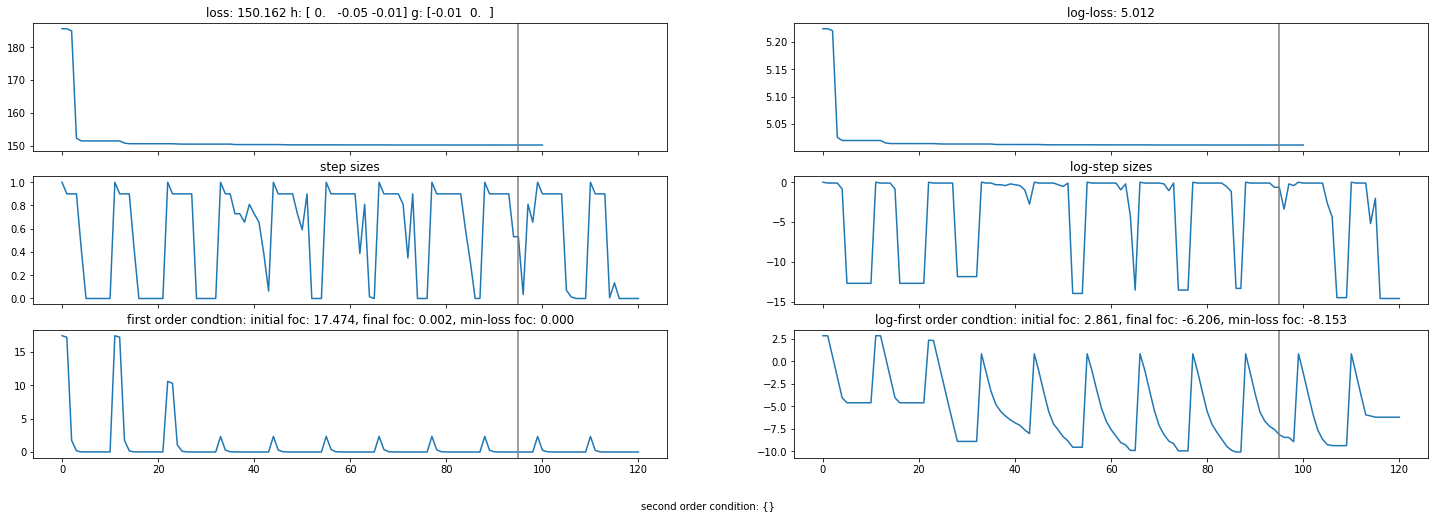

In [13]:
resgraph = utils.plot_results(result)

In [14]:
voxel_id, voxel_bound = voxel_cluster(X_k, np.array([5, 5]))

In [15]:
#utils.plot_graph(X_k, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(np.min(result['lossh']),2)), 
#                                                                            np.round(result['g'],2), np.round(result['g'],2), 
#                                                                           str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=voxel_id)

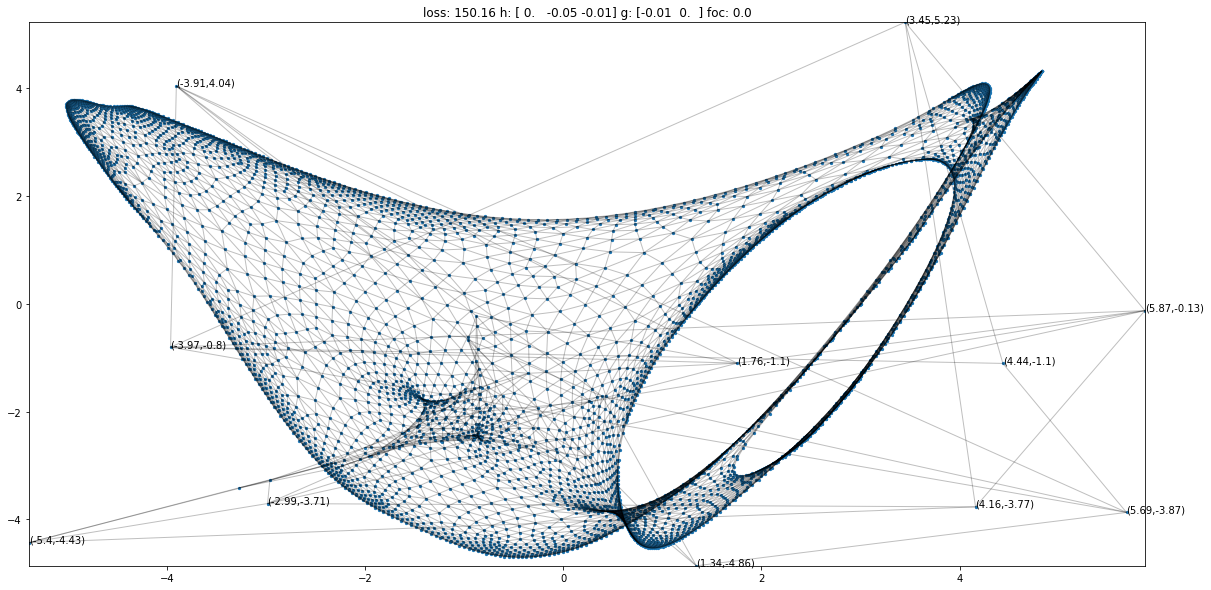

In [16]:
utils.plot_graph(X_k_n, graph, title='loss: {} h: {} g: {} foc: {}'.format(str(np.round(np.min(result['lossh']),2)), 
                                                                            np.round(result['h'],2), np.round(result['g'],2), 
                                                                           str(np.round(result['foc'][np.argmin(result['lossh'])],2))), fixed_indices=fixed_indices, c=None)

In [17]:
#utils.plot_animation(results, graph, fixed_coordinates=X_k_r[fixed_indices])